In [1]:
# Subir kaggle.json desde tu PC
from google.colab import files
files.upload()  # selecciona tu kaggle.json

# Instalar Kaggle CLI y mover credencial a la ruta correcta
!pip -q install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Prueba rápida (debería listar datasets que contengan 'fruits-360')
!kaggle datasets list -s "fruits-360" | head


Saving kaggle.json to kaggle.json
ref                                                  title                                             size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------  ------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
moltean/fruits                                       Fruits-360 dataset                          3761508859  2025-08-17 18:10:18.650000         197479       3233  0.875            
barisyasli/fruit360                                  fruits-360                                   362079657  2020-04-22 01:53:20.160000            379          5  0.4375           
souro12/ccxzvv                                       Fruits Images - 5 classes                     15299044  2020-04-01 09:49:55.777000            646          8  0.75             
ishandandekar/fruitimagedataset                      Fruit-Im

In [2]:
# Descarga y extracción
!kaggle datasets download -d moltean/fruits -p /content -q
!unzip -q /content/fruits.zip -d /content/fruits-360

# Localiza las carpetas Training y Test
!find /content/fruits-360 -maxdepth 3 -type d -name "Training" -o -name "Test" -print

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
/content/fruits-360/fruits-360_100x100/fruits-360/Test
/content/fruits-360/fruits-360_original-size/fruits-360-original-size/Test
/content/fruits-360/fruits-360_3-body-problem/fruits-360-3-body-problem/Test


## Preparación (rutas, librerías y salida de archivos)

In [3]:
# === Configuración básica ===
TRAIN_DIR = "/content/fruits-360/fruits-360_100x100/fruits-360/Training"
TEST_DIR  = "/content/fruits-360/fruits-360_100x100/fruits-360/Test"
OUTPUT_DIR = "/content/outputs"
import os; os.makedirs(OUTPUT_DIR, exist_ok=True)

# Limitar hilos para evitar cuelgues por RAM en Colab
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Librerías
!pip -q install scikit-image==0.24.0 threadpoolctl==3.5.0

import cv2, glob, time, random, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from threadpoolctl import threadpool_limits
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix)
plt.rcParams["figure.dpi"] = 120
random.seed(42); np.random.seed(42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 96.4 MB/s eta 0:00:00


## Descripción del dataset

In [4]:
import os, glob, cv2

classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
def count_images_in(root, classes):
    total=0
    for c in classes:
        total += len(glob.glob(os.path.join(root, c, "*.jpg"))) + len(glob.glob(os.path.join(root, c, "*.png")))
    return total

n_classes = len(classes)
n_train   = count_images_in(TRAIN_DIR, classes)
n_test    = count_images_in(TEST_DIR, classes)

# tamaño típico
sample = glob.glob(os.path.join(TRAIN_DIR, classes[0], "*.jpg"))[:1]
shape = cv2.imread(sample[0]).shape if sample else (100,100,3)

print(f"Clases: {n_classes}")
print(f"Imágenes Train: {n_train}")
print(f"Imágenes Test : {n_test}")
print(f"Tamaño típico : {shape} (alto, ancho, canales)")

# Guarda un JSON con la descripción para pegar en la slide
with open(f"{OUTPUT_DIR}/dataset_resumen.json","w") as f:
    json.dump({"classes":n_classes,"train":n_train,"test":n_test,"shape":shape}, f, indent=2)
print("Resumen guardado en:", f"{OUTPUT_DIR}/dataset_resumen.json")


Clases: 208
Imágenes Train: 105221
Imágenes Test : 35119
Tamaño típico : (100, 100, 3) (alto, ancho, canales)
Resumen guardado en: /content/outputs/dataset_resumen.json


## Preprocesamiento (CLAHE) + visualización

Guardado: /content/outputs/preproc_examples.png


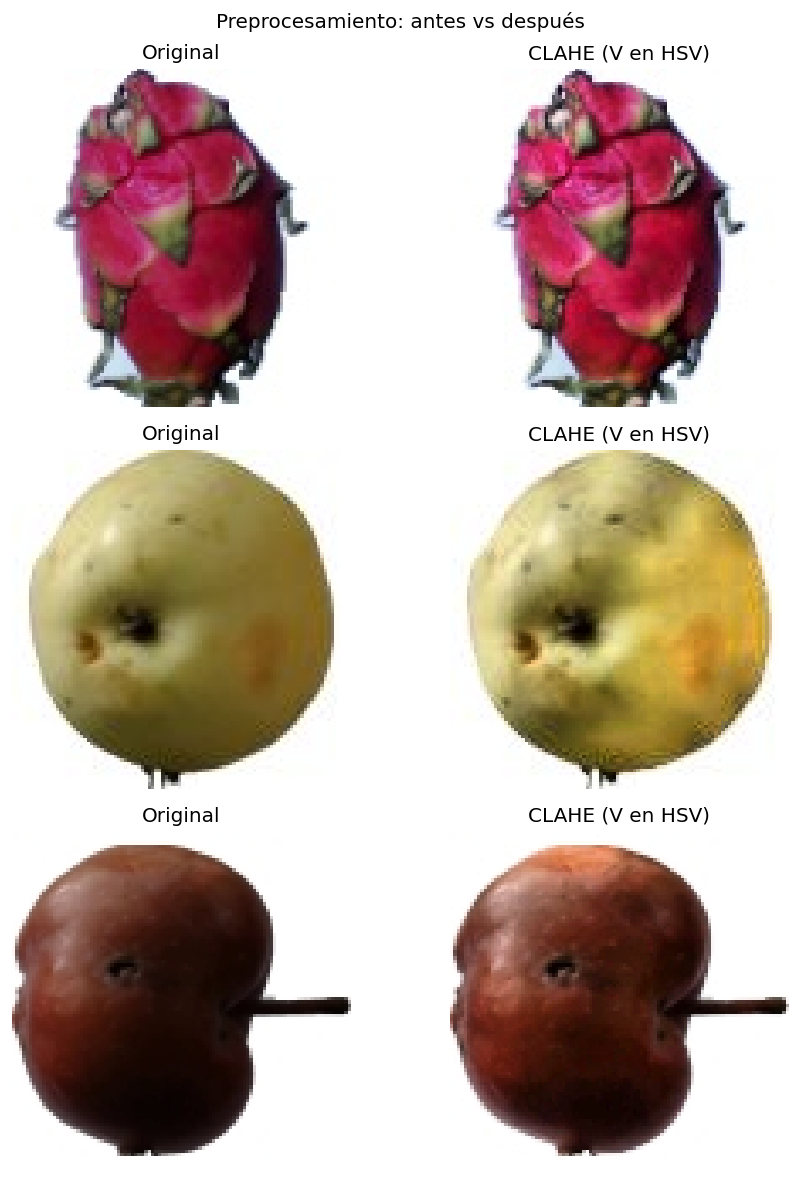

In [5]:
def apply_clahe_rgb(img_bgr, clipLimit=2.0, tileGridSize=(8,8)):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    v_eq = clahe.apply(v)
    hsv_eq = cv2.merge([h,s,v_eq])
    return cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2BGR)

# Visualiza 3 ejemplos antes/después
sample_paths = []
for cls in random.sample(classes, k=3):
    imgs = glob.glob(os.path.join(TRAIN_DIR, cls, "*.jpg"))
    if imgs: sample_paths.append(imgs[0])

fig, axes = plt.subplots(3,2, figsize=(8,10))
for i, p in enumerate(sample_paths):
    img = cv2.imread(p); img = cv2.resize(img, (100,100))
    eq = apply_clahe_rgb(img)
    axes[i,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); axes[i,0].set_title("Original"); axes[i,0].axis("off")
    axes[i,1].imshow(cv2.cvtColor(eq,  cv2.COLOR_BGR2RGB)); axes[i,1].set_title("CLAHE (V en HSV)"); axes[i,1].axis("off")
plt.suptitle("Preprocesamiento: antes vs después"); plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/preproc_examples.png"); print("Guardado:", f"{OUTPUT_DIR}/preproc_examples.png")


## Extracción de características + submuestreo balanceado

In [6]:
# Rasgos
def fe_hog(gray):
    return hog(gray, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2),
               block_norm='L2-Hys', feature_vector=True)

def fe_lbp(gray, P=8, R=1):
    lbp = local_binary_pattern(gray, P=P, R=R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P+3), range=(0, P+2))
    hist = hist.astype("float"); hist /= (hist.sum() + 1e-7)
    return hist

def fe_hsv_hist(img_bgr, bins=(8,8,8)):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0,180, 0,256, 0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_features_batch(X_imgs, use_clahe=True):
    feats = []
    for img in tqdm(X_imgs, desc="Extrayendo rasgos"):
        im = apply_clahe_rgb(img) if use_clahe else img
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        f = np.hstack([fe_hog(gray), fe_lbp(gray), fe_hsv_hist(im)])
        feats.append(f)
    return np.vstack(feats).astype(np.float32)

# Carga balanceada por clase (rápida)
def load_balanced(root_dir, classes, max_per_class=None):
    X, y = [], []
    for cls in classes:
        files = glob.glob(os.path.join(root_dir, cls, "*.jpg")) + glob.glob(os.path.join(root_dir, cls, "*.png"))
        if not files: continue
        if max_per_class:
            random.seed(42)
            files = random.sample(files, k=min(max_per_class, len(files)))
        for fp in files:
            img = cv2.imread(fp)
            if img is None: continue
            if img.shape[:2] != (100,100):
                img = cv2.resize(img,(100,100))
            X.append(img); y.append(cls)
    return np.array(X), np.array(y)

max_train_per_class = 30   # súbelo luego si puedes (p.ej. 60 u 80)
max_test_per_class  = 15

X_train_img, y_train = load_balanced(TRAIN_DIR, classes, max_per_class=max_train_per_class)
X_test_img,  y_test  = load_balanced(TEST_DIR,  classes, max_per_class=max_test_per_class)

print("Train:", X_train_img.shape, "Test:", X_test_img.shape, "Clases:", len(np.unique(y_train)))


Train: (6240, 100, 100, 3) Test: (3120, 100, 100, 3) Clases: 208


## Reducción de dimensión (PCA) + GridSearch “liviano”

In [7]:
# Extraer rasgos
USE_CLAHE = True
X_train = extract_features_batch(X_train_img, use_clahe=USE_CLAHE)
X_test  = extract_features_batch(X_test_img,  use_clahe=USE_CLAHE)

# Escalar + PCA (256 dims suele ir bien; prueba 128 si vas muy justo)
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

pca = PCA(n_components=256, svd_solver='randomized', random_state=42)
X_train_red = pca.fit_transform(X_train_sc)
X_test_red  = pca.transform(X_test_sc)

print("Dims originales:", X_train.shape[1], "→ PCA:", X_train_red.shape[1])
print("Varianza explicada (sum):", round(pca.explained_variance_ratio_.sum()*100,2), "%")


Extrayendo rasgos: 100%|██████████| 3120/3120 [00:29<00:00, 107.38it/s]


Dims originales: 4878 → PCA: 256
Varianza explicada (sum): 67.08 %


## Entrenamiento y evaluación (SVM-RBF, RF, KNN)

In [8]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_svm = GridSearchCV(
    SVC(kernel='rbf', cache_size=1000),
    param_grid={'C':[10,100], 'gamma':[1e-3,1e-4], 'class_weight':[None,'balanced']},
    scoring='f1_macro', cv=cv, n_jobs=2, pre_dispatch=2, verbose=1
)

grid_rf = GridSearchCV(
    RandomForestClassifier(n_jobs=1, random_state=42),
    param_grid={'n_estimators':[200], 'max_depth':[None,30]},
    scoring='f1_macro', cv=cv, n_jobs=2, pre_dispatch=2, verbose=1
)

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={'n_neighbors':[5,9], 'metric':['euclidean']},
    scoring='f1_macro', cv=cv, n_jobs=2, pre_dispatch=2, verbose=1
)

def fit_eval(grid, Xtr, ytr, Xte, yte, name):
    t0 = time.time()
    with threadpool_limits(limits=1):
        grid.fit(Xtr, ytr)
        yhat = grid.predict(Xte)
    res = {
        "Modelo": name,
        "Accuracy": accuracy_score(yte, yhat),
        "F1_macro": f1_score(yte, yhat, average='macro'),
        "Precision_macro": precision_score(yte, yhat, average='macro', zero_division=0),
        "Recall_macro": recall_score(yte, yhat, average='macro', zero_division=0),
        "Tiempo_fit_s": round(time.time()-t0,2),
        "BestParams": grid.best_params_
    }
    return res, yhat, grid.best_estimator_

results = []; preds_map = {}; best_est = None
for name, grid in [("SVM-RBF (PCA256)", grid_svm), ("RandomForest (PCA256)", grid_rf), ("KNN (PCA256)", grid_knn)]:
    r, yhat, est = fit_eval(grid, X_train_red, y_train, X_test_red, y_test, name)
    results.append(r); preds_map[name]=yhat
    if best_est is None or r["F1_macro"]>max(results, key=lambda x:x["F1_macro"])["F1_macro"]:
        best_est = est

df_results = pd.DataFrame(results)
display(df_results)
df_results.to_csv(f"{OUTPUT_DIR}/results_models.csv", index=False)
print("Resultados guardados en:", f"{OUTPUT_DIR}/results_models.csv")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


,Modelo,Accuracy,F1_macro,Precision_macro,Recall_macro,Tiempo_fit_s,BestParams
0,SVM-RBF (PCA256),0.864103,0.860511,0.884128,0.864103,285.35,"{'C': 10, 'class_weight': None, 'gamma': 0.0001}"
1,RandomForest (PCA256),0.733654,0.719853,0.743782,0.733654,875.08,"{'max_depth': None, 'n_estimators': 200}"
2,KNN (PCA256),0.668269,0.668964,0.760342,0.668269,6.23,"{'metric': 'euclidean', 'n_neighbors': 5}"


Resultados guardados en: /content/outputs/results_models.csv


## Matriz de confusión (Top-15 clases) + reporte

== Mejor modelo: SVM-RBF (PCA256) ==
Mejores hiperparámetros: {'C': 10, 'class_weight': None, 'gamma': 0.0001}
                           precision    recall  f1-score   support

                 Apple 10       0.81      0.87      0.84        15
                 Apple 11       1.00      1.00      1.00        15
                 Apple 12       1.00      1.00      1.00        15
                 Apple 13       1.00      1.00      1.00        15
                 Apple 14       0.93      0.93      0.93        15
                 Apple 17       0.71      1.00      0.83        15
                 Apple 18       1.00      0.87      0.93        15
                 Apple 19       1.00      0.73      0.85        15
                  Apple 5       1.00      1.00      1.00        15
                  Apple 6       1.00      1.00      1.00        15
                  Apple 7       1.00      1.00      1.00        15
                  Apple 8       0.76      0.87      0.81        15
                 

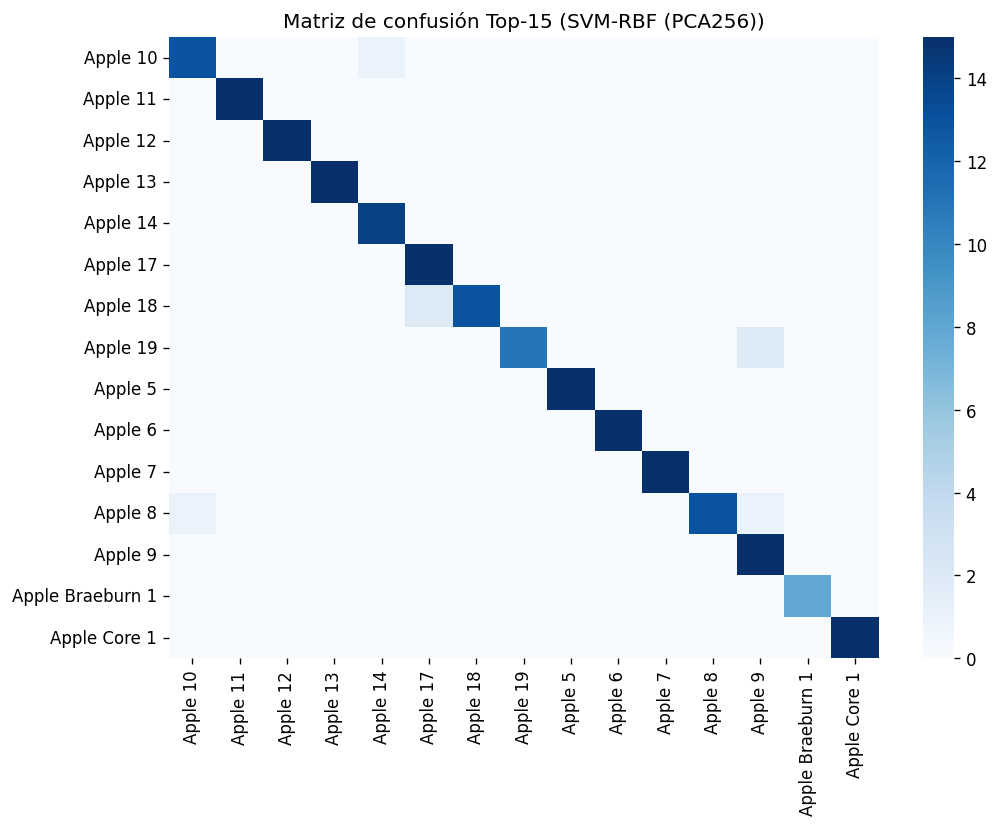

In [9]:
# Elige el mejor por F1-macro
best_row = df_results.sort_values("F1_macro", ascending=False).iloc[0]
best_name = best_row["Modelo"]; y_pred = preds_map[best_name]
print("== Mejor modelo:", best_name, "==")
print("Mejores hiperparámetros:", best_row["BestParams"])
print(classification_report(y_test, y_pred, zero_division=0))

# Top-15 clases más frecuentes en tu test
uniq, cnt = np.unique(y_test, return_counts=True)
top = [c for c,_ in sorted(zip(uniq,cnt), key=lambda x:x[1], reverse=True)[:15]]
mask = np.isin(y_test, top)
cm = confusion_matrix(y_test[mask], y_pred[mask], labels=top)

plt.figure(figsize=(9,7))
sns.heatmap(cm, cmap="Blues", xticklabels=top, yticklabels=top)
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.title(f"Matriz de confusión Top-15 ({best_name})")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/confusion_top15.png"); print("Guardado:", f"{OUTPUT_DIR}/confusion_top15.png")


In [10]:
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix

labels = sorted(np.unique(y_test))
cm = confusion_matrix(y_test, preds_map[best_name], labels=labels)

# Top 10 off-diagonal confusiones
errs = []
for i, li in enumerate(labels):
    for j, lj in enumerate(labels):
        if i!=j and cm[i,j]>0:
            errs.append((li, lj, int(cm[i,j])))
top_errs = sorted(errs, key=lambda x: x[2], reverse=True)[:10]
pd.DataFrame(top_errs, columns=["Real","Predicha","#Errores"])


,Real,Predicha,#Errores
0,Apple Red 3,Nectarine 1,8
1,Onion Red 1,Onion Red Peeled 1,8
2,Potato White 1,Onion White 1,7
3,Apple Granny Smith 1,Apple Golden 3,6
4,Beetroot 1,Cherimoya 1,6
5,Pear 1,Apple Golden 3,6
6,Potato Red Washed 1,Cactus fruit red 1,6
7,Cherry 2,Cherry 4,5
8,Grape Pink 1,Kumquats 1,5
9,Pear Monster 1,Cactus fruit 1,5


[Apple 17] n=3120 | TP=15 FP=6 FN=0 TN=3099
precision=0.714 recall=1.000 f1=0.833
Guardado: /content/outputs/confusion_2x2_Apple_17.png


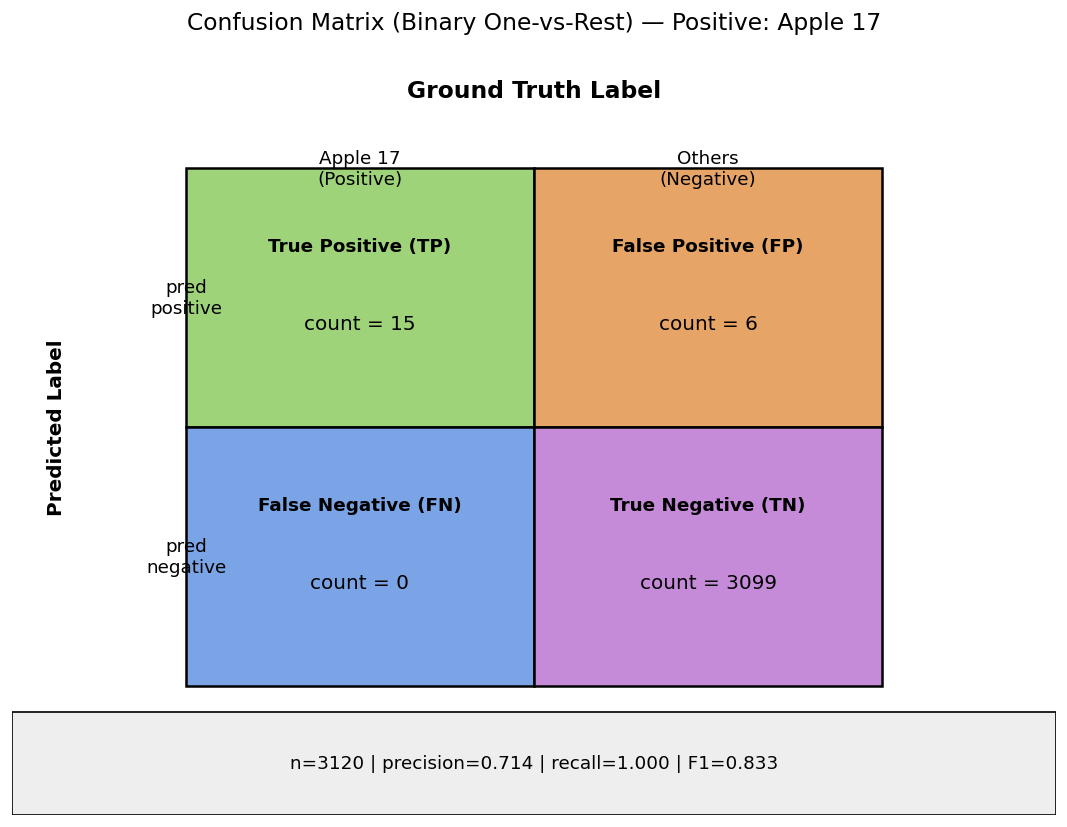

In [14]:
import numpy as np, matplotlib.pyplot as plt, os
from matplotlib.patches import Rectangle

# === Detectar y_true / y_pred del notebook ===
y_true = y_test
try:
    y_pred_all = y_pred_new
except NameError:
    try:
        y_pred_all = preds_map[best_name]
    except Exception:
        y_pred_all = y_pred  # si tenías y_pred

# === Elige la clase "positiva" (cámbiala por la que quieras mostrar) ===
target_class = "Apple 17"   # <-- cámbiala si quieres otra

# === Calcular TP/FP/FN/TN (one-vs-rest) ===
pos_true = (y_true == target_class)
pos_pred = (y_pred_all == target_class)

TP = int(np.sum(pos_true & pos_pred))
FP = int(np.sum(~pos_true & pos_pred))
FN = int(np.sum(pos_true & ~pos_pred))
TN = int(np.sum(~pos_true & ~pos_pred))
n  = TP + FP + FN + TN

prec = TP / (TP+FP) if (TP+FP)>0 else 0.0
rec  = TP / (TP+FN) if (TP+FN)>0 else 0.0
f1   = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0

print(f"[{target_class}] n={n} | TP={TP} FP={FP} FN={FN} TN={TN}")
print(f"precision={prec:.3f} recall={rec:.3f} f1={f1:.3f}")

# === Dibujo estilo "Confusion Matrix" binaria con colores y textos ===
fig, ax = plt.subplots(figsize=(9,7))
ax.set_xlim(0, 3); ax.set_ylim(0, 3)
ax.axis('off')

# Encabezados
ax.text(1.5, 2.8, "Ground Truth Label", ha='center', va='center', fontsize=14, fontweight='bold')
ax.text(0.1, 1.5, "Predicted Label", ha='left', va='center', rotation=90, fontsize=12, fontweight='bold')

# Sub-encabezados (verdadero positivo/negativo)
ax.text(1, 2.5, f"{target_class}\n(Positive)", ha='center', va='center', fontsize=11)
ax.text(2, 2.5, "Others\n(Negative)", ha='center', va='center', fontsize=11)
ax.text(0.5, 2, "pred\npositive", ha='center', va='center', fontsize=11)
ax.text(0.5, 1, "pred\nnegative", ha='center', va='center', fontsize=11)

# Celdas 2x2 (colores aproximados al ejemplo)
cells = [
    (1, 2, TP, "True Positive (TP)",  "#9fd37a"),   # verde
    (2, 2, FP, "False Positive (FP)", "#e6a566"),   # naranja
    (1, 1, FN, "False Negative (FN)", "#7aa4e6"),   # azul
    (2, 1, TN, "True Negative (TN)",  "#c58bd9")    # morado
]
for x, y, val, label, color in cells:
    ax.add_patch(Rectangle((x-0.5, y-0.5), 1, 1, facecolor=color, edgecolor='black', linewidth=1.5))
    ax.text(x, y+0.2, label, ha='center', va='center', fontsize=11, fontweight='bold')
    ax.text(x, y-0.1, f"count = {val}", ha='center', va='center', fontsize=12)

# Totales (márgenes)
ax.add_patch(Rectangle((0, 0), 3, 0.4, facecolor="#eeeeee", edgecolor='black', linewidth=1))  # barra inferior (stats)
ax.text(1.5, 0.2, f"n={n} | precision={prec:.3f} | recall={rec:.3f} | F1={f1:.3f}", ha='center', va='center', fontsize=11)

ax.set_title(f"Confusion Matrix (Binary One-vs-Rest) — Positive: {target_class}", fontsize=14)
plt.tight_layout()

# Guardar para la diapositiva
os.makedirs("/content/outputs", exist_ok=True)
out_path = f"/content/outputs/confusion_2x2_{target_class.replace(' ','_')}.png"
plt.savefig(out_path, dpi=150)
print("Guardado:", out_path)
plt.show()


Clase con peor F1 (one-vs-rest): Banana Lady Finger 1
Guardado: /content/outputs/confusion_2x2_Banana_Lady_Finger_1.png


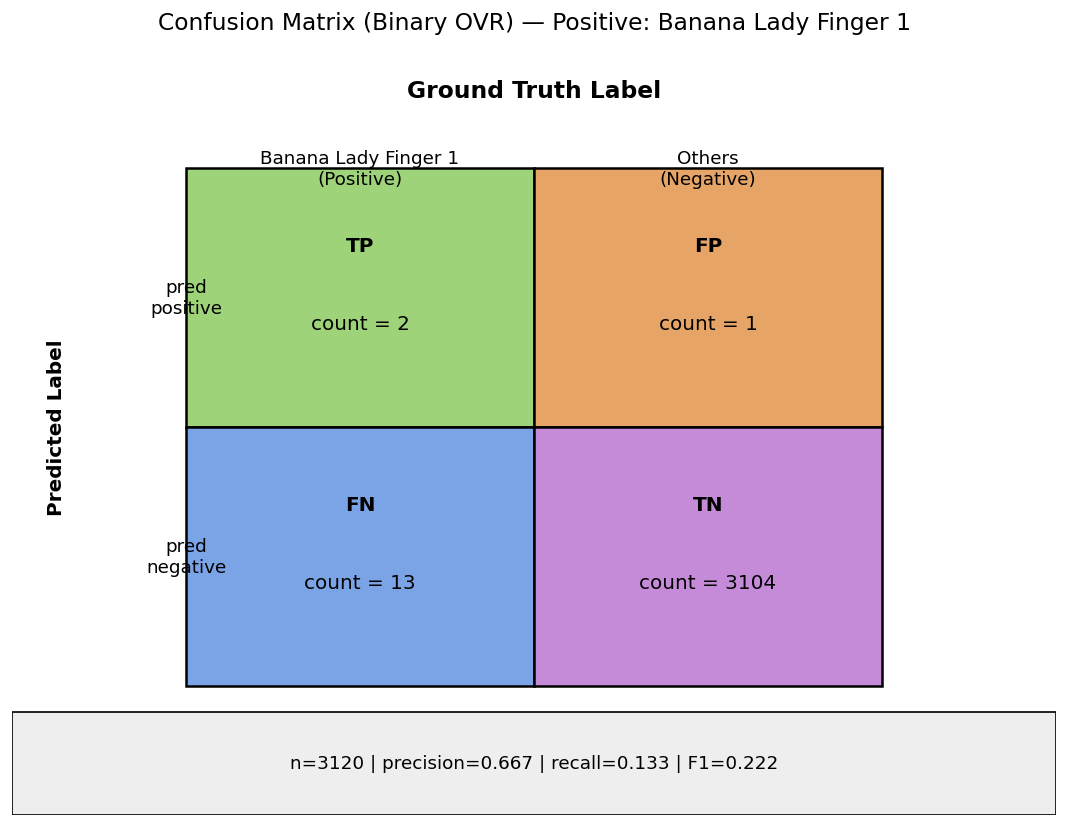

In [15]:
# Encuentra la clase con peor F1 (one-vs-rest) y dibuja su 2×2
uniq = np.unique(y_true)
def f1_ovr(c):
    pt = (y_true==c); pp = (y_pred_all==c)
    TP = np.sum(pt & pp); FP = np.sum(~pt & pp); FN = np.sum(pt & ~pp)
    prec = TP/(TP+FP) if (TP+FP)>0 else 0
    rec  = TP/(TP+FN) if (TP+FN)>0 else 0
    return 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0

worst = min(uniq, key=f1_ovr)
print("Clase con peor F1 (one-vs-rest):", worst)
target_class = worst

# Reusa el bloque de dibujo anterior rápidamente:
pos_true = (y_true == target_class); pos_pred = (y_pred_all == target_class)
TP = int(np.sum(pos_true & pos_pred)); FP = int(np.sum(~pos_true & pos_pred))
FN = int(np.sum(pos_true & ~pos_pred)); TN = int(np.sum(~pos_true & ~pos_pred)); n = TP+FP+FN+TN
prec = TP/(TP+FP) if (TP+FP)>0 else 0.0; rec = TP/(TP+FN) if (TP+FN)>0 else 0.0
f1 = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0

fig, ax = plt.subplots(figsize=(9,7)); ax.set_xlim(0,3); ax.set_ylim(0,3); ax.axis('off')
ax.text(1.5, 2.8, "Ground Truth Label", ha='center', va='center', fontsize=14, fontweight='bold')
ax.text(0.1, 1.5, "Predicted Label", ha='left', va='center', rotation=90, fontsize=12, fontweight='bold')
ax.text(1, 2.5, f"{target_class}\n(Positive)", ha='center', va='center', fontsize=11)
ax.text(2, 2.5, "Others\n(Negative)", ha='center', va='center', fontsize=11)
ax.text(0.5, 2, "pred\npositive", ha='center', va='center', fontsize=11)
ax.text(0.5, 1, "pred\nnegative", ha='center', va='center', fontsize=11)
cells = [(1,2,TP,"TP","#9fd37a"),(2,2,FP,"FP","#e6a566"),(1,1,FN,"FN","#7aa4e6"),(2,1,TN,"TN","#c58bd9")]
for x,y,val,label,color in cells:
    ax.add_patch(Rectangle((x-0.5,y-0.5),1,1,facecolor=color,edgecolor='black',linewidth=1.5))
    ax.text(x,y+0.2,label,ha='center',va='center',fontsize=12,fontweight='bold')
    ax.text(x,y-0.1,f"count = {val}",ha='center',va='center',fontsize=12)
ax.add_patch(Rectangle((0,0),3,0.4,facecolor="#eeeeee",edgecolor='black',linewidth=1))
ax.text(1.5,0.2,f"n={n} | precision={prec:.3f} | recall={rec:.3f} | F1={f1:.3f}",ha='center',va='center',fontsize=11)
ax.set_title(f"Confusion Matrix (Binary OVR) — Positive: {target_class}", fontsize=14)
plt.tight_layout(); path = f"/content/outputs/confusion_2x2_{target_class.replace(' ','_')}.png"
plt.savefig(path, dpi=150); print("Guardado:", path); plt.show()
